# Redes Neuronales
## Introduction

Se implementan redes neuronales para reconocer digitos manuscritos.

Primero se importan las librerias requeridas.

In [9]:
# utilizado para manipular rutas y directorios
import os

# Computación cientifica y vectorial para Python
import numpy as np

# Libreria para gráficos
from matplotlib import pyplot

# Modulo de optimización
from scipy import optimize

# Modulo para cargar archivos de datos en formato MATLAB
from scipy.io import loadmat

# llama a matplotlib para embeber graficos en el cuadernillo
%matplotlib inline

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.1 Dataset

Se tiene el dataset `ex3data1.mat` que contiene 5000 ejemplos de entrenamiento de digitos manuscritos(Esto es un subconjunto de  [MNIST](http://yann.lecun.com/exdb/mnist) dataset de digitos manuscritos). La extensión de formato `.mat` significa que los datos han sido guardados en el formato de matriz Octave/MATLAB, en lugar de un archivo de texto formato(ASCII) como un archivo csv-file. Python dispone de mecanismos para cargar un formato MATLAB utilizando la función `loadmat` de la libreria `scipy.io`. Esta funcion devuelve un diccionario con las llaves que contienen el nombre de variables dentro del archivo `.mat`.

Hay ejemplos de entrenamiento en `ex3data1.mat`, donde cada ejemplo de entrenamiento es una imagen en escala de grises de 20 por 20 pixeles. Cada pixel es representado por un numero de punto flotante indicando la intensidad en la escala de grises en una posicion. Los 20 por 20 piseles se enrrolla en un vector unidimensional de 400 elementos. Cada uno de los ejemplos de entrenamiento es una fila en la matriz `X`. Esto da una matriz `X` de 5000 por 400, donde cada fila es un ejemplo de entrenamiento de una imagen de un digito manuscrito.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

La segunda parte del conjunto de entrenamiento es un vector de 500 dimensiones `y` que contiene etiquetas para para el conjunto de entrenamiento.

Se inicia cargando el dataset.

In [11]:
#  datos de entrenamiento almacenado en los arreglos X, y
# data = loadmat(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/machine learning/data', 'ex3data1.mat'))
data = loadmat('/content/gdrive/MyDrive/Colab Notebooks/machine learning/datasets/ex3data1.mat')

In [27]:
# print(data['X'])
# print(data['X'].shape)

print(data['y'])
print(data['y'].shape)

X, y = data['X'], data['y'].ravel()
print(y)
print(y.shape)

# # Se conierte la etiqueta 10 a 0
# y[y == 10] = 0

m = y.size

# # se permutan los ejemplos, para ser usados para visualizar ina imagen a la vez
indices = np.random.permutation(m)

# # # Randomicamente selecciona 100 puntos de datos para visualizar
# rand_indices = np.random.choice(m, 100, replace=False)
# sel = X[rand_indices, :]

# displayData(sel)

[[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]
(5000, 1)
[10 10 10 ...  9  9  9]
(5000,)


In [13]:
len(X)

5000

### 1.2 Visualización de los datos

Se elige aleatoriamente 100 filas de `X` y se pasan las mismas a la funcion `displayData`. Esta función mapea cada fila en una imagen de 20x20 en escala de grises, mostrando todas las imagenes juntas.

In [14]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

In [15]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

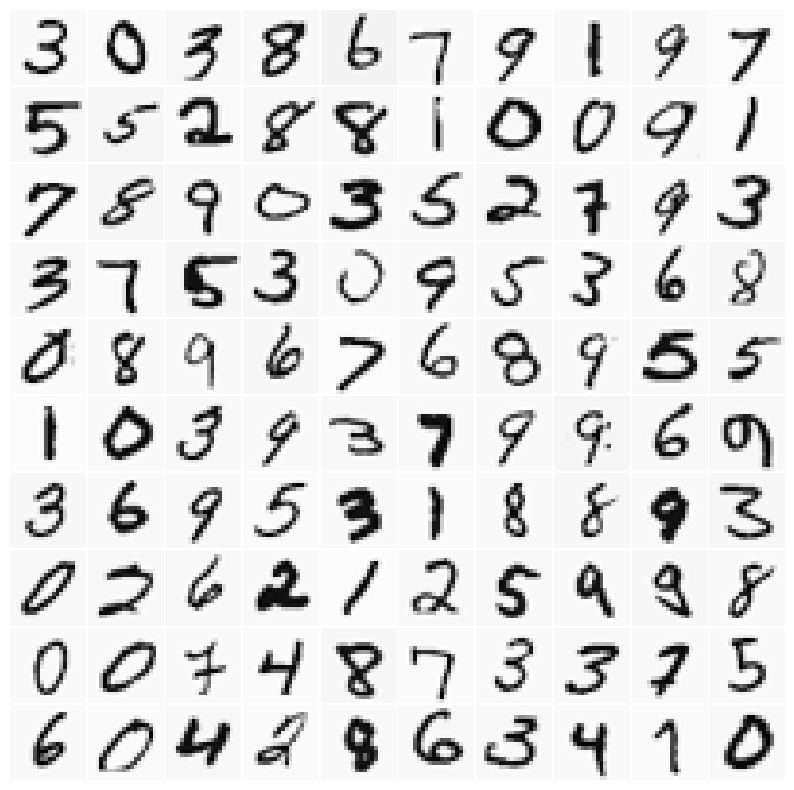

In [18]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

La regresión logistica no puede formar hipotesis complejas, con un clasificador lineal, por lo que se deben agregar mas caracteristicas como es el caso de las regresiones polinomiales, sin embargo estas requieren muchos recursos para su entrenamiento.

Se implementa la propagacin hacia adelante para utilizar unos pesos suministrados para realizar las predicciones

Se inicia cargando y visualizando el dataset que contiene los digitos manuscritos.


### 2.1 Representación del modelo

La red neuronal se muestra en la siguiente figura.

![Neural network](Figures/neuralnetwork.png)

Esta red tiene 3 capas: una capa de entrada, una capa oculta y una capa de salida. Recuerde que las entradas son valores de píxeles de imágenes de dígitos. Dado que las imágenes son de tamaño 20 × 20, esto nos da 400 unidades de capa de entrada (excluyendo la unidad de oscilación adicional que siempre genera +1). Como antes, los datos de entrenamiento se cargarán en las variables X e y.
Se proporciona parametros ($\Theta^{(1)}$, $\Theta^{(2)}$), por lo cual en este ejercicio no se calculara theta, los valores de tetha esta almacenados en `ex3weights.mat`. En la siguiente selda se cargan los parametros en `Theta1` y `Theta2`. Los parametros tienen dimensiones son adecuadas a la redneuronal con 25 unidades en la segunda capa y 10 unidades de salida que corresponden con los 10 digitos de las lases.

In [19]:
# Configura los parámetros que se requieren
input_layer_size  = 400  # Entrada Imagen de Digitos de 20x20
hidden_layer_size = 25   # 25 unidades ocultas
num_labels = 10          # 10 etiquetas, del 1 al 10 (se remapea el numero 10 con el valor de 0)

# Carga el archivo .mat, que devuelve un diccionario
# weights = loadmat(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/machine learning/data', 'ex3weights.mat'))
weights = loadmat('/content/gdrive/MyDrive/Colab Notebooks/machine learning/datasets/ex3weights.mat')

# obtine el modelo de pesos del diccionario
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

In [20]:
# print(Theta1)
# print(len(Theta1))
# print(Theta1.shape)

print(Theta2[:, 0])
print(len(Theta2))
print(Theta2.shape)

a = np.roll(Theta2, 1, axis=0)
print(a[:, 0])
print(len(a))
print(a.shape)



# intercambia la primera y la última columna de Theta2, debido al legado de la indexación de MATLAB,
# desde que el archivo de peso ex3weights.mat se guardó según la indexación de MATLAB
Theta2 = np.roll(Theta2, 1, axis=0)

[-0.76100352 -0.61785176 -0.68934072 -0.67832479 -0.59664339 -0.87794907
 -0.52746527 -0.7490154  -0.6665468  -0.46089119]
10
(10, 26)
[-0.46089119 -0.76100352 -0.61785176 -0.68934072 -0.67832479 -0.59664339
 -0.87794907 -0.52746527 -0.7490154  -0.6665468 ]
10
(10, 26)


In [21]:
Theta1.shape

(25, 401)

In [22]:
Theta2.shape

(10, 26)

<a id="section4"></a>
### 2.2 Propagación hacia adelante y predicción

<a id="predict"></a>

In [24]:
def predict(Theta1, Theta2, X):
    # Asegúrar que la entrada tenga dos dimensiones
    if X.ndim == 1:
        X = X[None]  # promover a dos dimensiones

    # Variables utiles
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    p = np.zeros(X.shape[0])

    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    a2 = sigmoid(X.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)

    a3 = sigmoid(a2.dot(Theta2.T))
    # a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)


    # p = np.argmax(sigmoid(a2.dot(Theta2.T)), axis = 1)
    p = np.argmax(a3, axis = 1)
    return p

In [25]:
pred = predict(Theta1, Theta2, X)
print(len(pred))
print('El error (J- costo) del conjunto de entrenamiento: {:.1f}%'.format(np.mean(pred == y) * 100))

5000
El error (J- costo) del conjunto de entrenamiento: 87.6%


Después de eso, mostraremos las imágenes del conjunto de entrenamiento de una en una, mientras que al mismo tiempo imprimiremos la etiqueta prevista para la imagen mostrada.

Ejecute la siguiente celda para mostrar una sola imagen de la predicción de la red neuronal. Puede ejecutar la celda varias veces para ver predicciones para diferentes imágenes.

Predicción de la red neuronal: 6


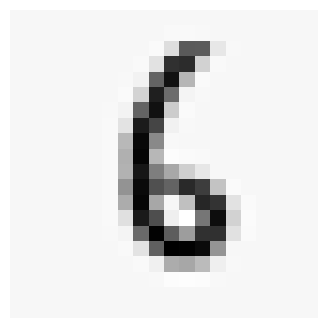

In [31]:
indices = np.random.permutation(m)

if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Predicción de la red neuronal: {}'.format(*pred))
else:
    print('No hay mas imagenes para mostrary!')